In [2]:
# !pip install --upgrade keras
# !pip install --upgrade tensorflow

In [42]:
import json
import typing as t
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Get files from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! unzip ./drive/MyDrive/soundscapes-mel-sgrams.zip -d . # files at ./data/processed/soundsapes-mel-sgrams/*.npy
# ! rm -rf data # to remove folders

Archive:  ./drive/MyDrive/soundscapes-mel-sgrams.zip
replace ./data/processed/soundscapes-mel-sgrams/13. Fortune Teller.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Utils

In [8]:
def load_mel_sgram_files(path: Path) -> t.List[t.Dict[str, np.ndarray | str]]:
    """
    Load mel spectrogram files from a given directory.

    Parameters
    -----------
    path : Path
        The path to the directory containing mel spectrogram files in numpy format (.npy).

    Returns
    -------
    List[Dict[str, Union[np.ndarray, str]]]
        A list of dictionaries, where each dictionary contains the file name (without extension) and the corresponding numpy array data.

    Example:
    ```python
    path_to_files = Path('/path/to/your/files')
    loaded_data = load_mel_sgram_files(path_to_files)

    for entry in loaded_data:
        print(f"File: {entry['file_name']}, Shape: {entry['data'].shape}")
    ```
    """
    mel_sgram_files = path.glob('*.npy')
    data_list = []

    for file_path in mel_sgram_files:
        try:
            data = np.load(file_path)
            file_name = file_path.name  # Get the file name with extension
            entry = {'file_name': file_name, 'data': data}
            data_list.append(entry)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return data_list

def generate_sgram_tensor(data_info: t.List[t.Dict[str, np.ndarray | str]]) -> t.Dict[str, t.Dict[int,str] | np.ndarray]:
    """
    Generate a 3D tensor containing mel spectrogram samples and a mapping from tensor positions to file names.

    Parameters:
    - data_info (List[Dict[str, Union[np.ndarray, str]]]): A list of dictionaries containing file names and corresponding
      numpy array data, typically obtained from the `load_mel_sgram_files` function.

    Returns:
    - Dict[str, Union[Dict[str, int], np.ndarray]]: A dictionary with two keys:
        - 'tensor': a 3D numpy array containing all mel spectrogram samples.
        - 'mapping': a dictionary mapping the tensor's first position to the corresponding file name.

    Example:
    ```python
    loaded_data = load_mel_sgram_files(Path('/path/to/your/files'))
    sgram_tensor_info = generate_sgram_tensor(loaded_data)
    tensor = sgram_tensor_info['tensor']
    mapping = sgram_tensor_info['mapping']
    ```
    """
    num_samples = len(data_info)
    max_length = max(data['data'].shape[0] for data in data_info)

    # Initialize the tensor with zeros
    sgram_tensor = np.zeros((num_samples, max_length, data_info[0]['data'].shape[1]))
    mapping = {}

    for i, data in enumerate(data_info):
        length = data['data'].shape[0]
        sgram_tensor[i, :length, :] = data['data']
        mapping[i] = data['file_name']

    return {'tensor': sgram_tensor, 'mapping': mapping}

In [9]:
class ConvAutoEncoder(Model):
  def __init__(self,
               input_shape,
               conv_filters = (16,32),
               latent_dim = 2):
    super(ConvAutoEncoder, self).__init__()

    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    encoder_layer_1 = layers.Conv2D(conv_filters[0], (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
    encoder_layer_2 = layers.Conv2D(conv_filters[1], (3, 3), activation='relu', padding='same', strides=2)(encoder_layer_1)
    encoder_layer_3 = layers.Flatten()(encoder_layer_2)
    encoder_layer_4 = layers.Dense(latent_dim,
                                   kernel_regularizer='l2')(encoder_layer_3)
    self.encoder = Model(encoder_input,
                         encoder_layer_4,
                         name = 'encoder')

    # Decoder
    decoder_input = layers.Input(shape = (latent_dim,))
    decoder_layer_1 = layers.Dense(units=32*1689*conv_filters[1],
                                   kernel_regularizer='l2')(decoder_input)
    decoder_layer_2 = layers.Reshape(target_shape=(32,1689,conv_filters[1]))(decoder_layer_1)
    decoder_layer_3 = layers.Conv2DTranspose(conv_filters[1], kernel_size=3, strides=2, activation='relu', padding='same')(decoder_layer_2)
    decoder_layer_4 = layers.Conv2DTranspose(conv_filters[0], kernel_size=3, strides=2, activation='relu', padding='same')(decoder_layer_3)
    decoder_layer_5 = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder_layer_4)
    self.decoder = Model(decoder_input,
                         decoder_layer_5,
                         name = 'decoder')

  def encode(self,x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Loading data in-memory

In [10]:
sgram_folder = Path('./data/processed/soundscapes-mel-sgrams')
assert sgram_folder.exists()
data_list = load_mel_sgram_files(sgram_folder)

In [11]:
t = np.array([d_l['data'] for d_l in data_list]) # This is the tensor I want
tensor_obj = generate_sgram_tensor(data_list)
assert tensor_obj['tensor'].shape == (24,128,6755)
assert (tensor_obj['tensor'] == t).all() # Just to be sure

In [12]:
# Assuming tensor_obj['tensor'] has shape (24, 128, 6755)
desired_shape = (24, 128, 6756)

# Calculate the padding along the third dimension
padding = ((0, 0), (0, 0), (0, desired_shape[2] - tensor_obj['tensor'].shape[2]))

# Pad the tensor with zeros
padded_tensor = np.pad(tensor_obj['tensor'], padding, mode='constant', constant_values=0)

# Verify the shape
assert padded_tensor.shape == desired_shape

# Now, you can use padded_tensor as your input tensor
tensor_obj['tensor'] = padded_tensor

In [13]:
# Getting right shape
tensor_obj['tensor'] = tensor_obj['tensor'][..., tf.newaxis]
assert tensor_obj['tensor'].shape == (24,128,6756,1)

In [14]:
tensor_obj['tensor'] = tensor_obj['tensor'] / tensor_obj['tensor'].max()
assert tensor_obj['tensor'].max() == 1.0

# Running autoencoder

In [15]:
autoencoder = ConvAutoEncoder((128, 6756,1),
                              (32,64))
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [23]:
history = autoencoder.fit(
    tensor_obj['tensor'],
    tensor_obj['tensor'],
    epochs=50,
    shuffle = True,
    validation_split = 0.15
)

Epoch 1/50
1/1 [==============================] - 48s 48s/step - loss: 0.0420 - val_loss: 0.0597
Epoch 2/50
1/1 [==============================] - 46s 46s/step - loss: 0.0586 - val_loss: 0.0710
Epoch 3/50
1/1 [==============================] - 42s 42s/step - loss: 0.0700 - val_loss: 0.0598
Epoch 4/50
1/1 [==============================] - 45s 45s/step - loss: 0.0589 - val_loss: 0.0457
Epoch 5/50
1/1 [==============================] - 43s 43s/step - loss: 0.0449 - val_loss: 0.0405
Epoch 6/50
1/1 [==============================] - 45s 45s/step - loss: 0.0399 - val_loss: 0.0430
Epoch 7/50
1/1 [==============================] - 42s 42s/step - loss: 0.0426 - val_loss: 0.0465
Epoch 8/50
1/1 [==============================] - 44s 44s/step - loss: 0.0463 - val_loss: 0.0465
Epoch 9/50
1/1 [==============================] - 42s 42s/step - loss: 0.0465 - val_loss: 0.0430
Epoch 10/50
1/1 [==============================] - 44s 44s/step - loss: 0.0433 - val_loss: 0.0387
Epoch 11/50
1/1 [============

In [26]:
autoencoder.summary()

Model: "conv_auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2)                 6936962   
                                                                 
 decoder (Functional)        (None, 128, 6756, 1)      10432897  
                                                                 
Total params: 17369859 (66.26 MB)
Trainable params: 17369859 (66.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


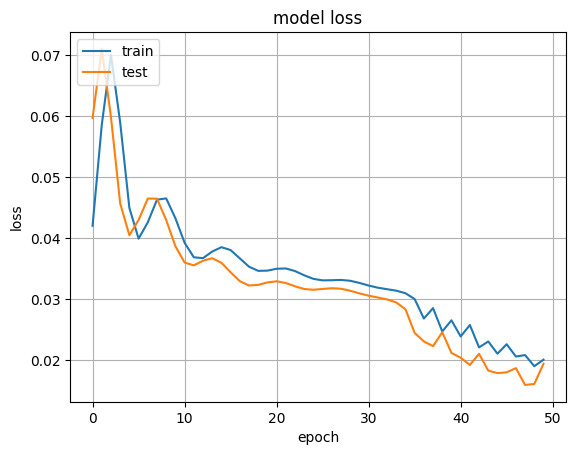

In [27]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [28]:
sample = tensor_obj['tensor'][0,:,:]
sample = sample[tf.newaxis,...]
sample.shape

(1, 128, 6756, 1)

In [29]:
embeddings = autoencoder.encode(
    tensor_obj['tensor']
).numpy()

In [30]:
embeddings

array([[  4.736777 , -61.894936 ],
       [  4.4671583, -57.909126 ],
       [  4.9723325, -64.22405  ],
       [  4.7074413, -60.27318  ],
       [  5.128002 , -64.9858   ],
       [  5.312803 , -67.842026 ],
       [  5.5002856, -68.65294  ],
       [  5.246337 , -66.38779  ],
       [  5.4821877, -69.21408  ],
       [  5.382165 , -69.05252  ],
       [  5.157629 , -66.756516 ],
       [  4.786135 , -60.95588  ],
       [  4.9272623, -63.450756 ],
       [  5.24569  , -66.82993  ],
       [  5.4734025, -68.09786  ],
       [  4.772075 , -63.616512 ],
       [  4.529189 , -58.25381  ],
       [  4.82617  , -61.49837  ],
       [  5.226358 , -65.70996  ],
       [  5.239163 , -66.04463  ],
       [  5.0974755, -65.380356 ],
       [  5.3014264, -66.970825 ],
       [  5.84108  , -72.63812  ],
       [  5.45932  , -68.29741  ]], dtype=float32)

In [31]:
tensor_obj['mapping']

{0: '19. The Silly Pink Rabbit!.npy',
 1: '13. Fortune Teller.npy',
 2: '14. Soldiers of Kakariko Village.npy',
 3: '02. Beginning of the Journey.npy',
 4: '21. Forest of Mystery.npy',
 5: '26. Black Mist (Storm).npy',
 6: '24. Dark Golden Land.npy',
 7: '12. Guessing-Game House.npy',
 8: '03. Seal of Seven Maidens.npy',
 9: '05. Time of the Falling Rain (Storm).npy',
 10: '07. Majestic Castle (Storm).npy',
 11: '09. Safety in the Sanctuary.npy',
 12: '06. Majestic Castle.npy',
 13: '04. Time of the Falling Rain.npy',
 14: "08. Princess Zelda's Rescue.npy",
 15: '20. The Silly Pink Rabbit! (Storm).npy',
 16: '29. The Goddess Appears.npy',
 17: '15. Dank Dungeons.npy',
 18: '25. Black Mist.npy',
 19: '27. Dungeon of Shadows.npy',
 20: '16. Lost Ancient Ruins.npy',
 21: '11. Kakariko Village.npy',
 22: '17. Anger of the Guardians.npy',
 23: '10. Hyrule Field Main Theme.npy'}

In [40]:
output = dict()
for it, title in tensor_obj['mapping'].items():
  position = embeddings[it,:].tolist()
  print(f'We have the tune | {title} | in the {it}-th track. Embedded Point = {position} ')
  output[title] = position

We have the tune | 19. The Silly Pink Rabbit!.npy | in the 0-th track. Embedded Point = [4.736776828765869, -61.894935607910156] 
We have the tune | 13. Fortune Teller.npy | in the 1-th track. Embedded Point = [4.467158317565918, -57.90912628173828] 
We have the tune | 14. Soldiers of Kakariko Village.npy | in the 2-th track. Embedded Point = [4.97233247756958, -64.22405242919922] 
We have the tune | 02. Beginning of the Journey.npy | in the 3-th track. Embedded Point = [4.707441329956055, -60.27317810058594] 
We have the tune | 21. Forest of Mystery.npy | in the 4-th track. Embedded Point = [5.128002166748047, -64.98580169677734] 
We have the tune | 26. Black Mist (Storm).npy | in the 5-th track. Embedded Point = [5.312802791595459, -67.84202575683594] 
We have the tune | 24. Dark Golden Land.npy | in the 6-th track. Embedded Point = [5.500285625457764, -68.65293884277344] 
We have the tune | 12. Guessing-Game House.npy | in the 7-th track. Embedded Point = [5.246336936950684, -66.387

In [41]:
output

{'19. The Silly Pink Rabbit!.npy': [4.736776828765869, -61.894935607910156],
 '13. Fortune Teller.npy': [4.467158317565918, -57.90912628173828],
 '14. Soldiers of Kakariko Village.npy': [4.97233247756958,
  -64.22405242919922],
 '02. Beginning of the Journey.npy': [4.707441329956055, -60.27317810058594],
 '21. Forest of Mystery.npy': [5.128002166748047, -64.98580169677734],
 '26. Black Mist (Storm).npy': [5.312802791595459, -67.84202575683594],
 '24. Dark Golden Land.npy': [5.500285625457764, -68.65293884277344],
 '12. Guessing-Game House.npy': [5.246336936950684, -66.38778686523438],
 '03. Seal of Seven Maidens.npy': [5.482187747955322, -69.21408081054688],
 '05. Time of the Falling Rain (Storm).npy': [5.38216495513916,
  -69.05252075195312],
 '07. Majestic Castle (Storm).npy': [5.157629013061523, -66.75651550292969],
 '09. Safety in the Sanctuary.npy': [4.786135196685791, -60.95587921142578],
 '06. Majestic Castle.npy': [4.927262306213379, -63.45075607299805],
 '04. Time of the Falli

In [43]:
with open('embeddings.json', 'w') as fp:
    json.dump(output, fp)

# Refs
[VAE](https://www.tensorflow.org/tutorials/generative/cvae)

[AE](https://www.tensorflow.org/tutorials/generative/autoencoder)